In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 bird plane horse   cat


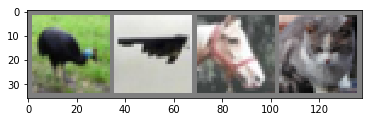

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

from box_convolution import BoxConv2d



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = BoxConv2d(3, 10, 32, 32)
        self.conv1_1x1 = nn.Conv2d(3, 3, 1, 1)

        self.fc1 = nn.Linear(8*8*30, 10)

    def forward(self, x):
        # The following line computes responses to 40 "generalized Haar filters"
        x = self.conv1(self.conv1_1x1(x))
        x = F.relu(F.max_pool2d(x, 4))

        x = self.fc1(x.view(-1, 8*8*30))
        return F.log_softmax(x, dim=1)


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [7]:
len(trainset)

50000

In [ ]:
from tqdm import tqdm

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=int(50000/4)):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

 16%|█▌        | 2007/12500 [00:58<04:37, 37.80it/s]

[1,  2000] loss: 1.953


 32%|███▏      | 4007/12500 [01:58<04:21, 32.49it/s]

[1,  4000] loss: 1.779


 48%|████▊     | 6004/12500 [02:59<02:51, 37.89it/s]

[1,  6000] loss: 1.713


 64%|██████▍   | 7993/12500 [03:57<02:44, 27.32it/s]

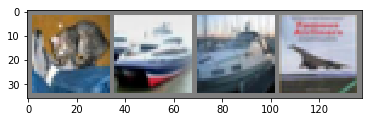

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(images)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
images.shape

torch.Size([4, 3, 32, 32])

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   cat   cat   cat


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
torch.save(net, 'model.pt')

In [ ]:
dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(net, dummy_input, 'model.onnx')

In [ ]:
torch.save(net, 'model.pt')